Task:

made classification dataset based on RNN, GRU, LSTM

#Import libraries

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import keras
from keras import layers
import tensorflow as tf
from tensorflow.keras.optimizers import Adam



import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from matplotlib import pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
print(keras.__version__)

3.4.1


In [87]:
tf.random.set_seed(42)

#Load data

In [4]:
path = "/content/drive/MyDrive/Hillel_ML_Course/12/hw/IMDB Dataset.csv"

In [135]:
data = pd.read_csv(path)

In [136]:
#chose first 10000 rows
data = data.iloc[:15000,:]

In [7]:
data.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


#Preprocess data

##clean text

In [8]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [137]:
# define new data variable
data_cleaned = data.copy()

In [138]:
data_cleaned["review"] = data_cleaned["review"].apply(lambda x: clean_text(x))

In [139]:
data_cleaned

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
14995,bobcat goldthwait should be commended for atte...,negative
14996,and its not because since her days on clarissa...,positive
14997,a traveling couple horton and hamiltonstumble ...,negative
14998,this film is deeply disappointing not only tha...,negative


## remove stopwords

In [140]:
#download stopwords from nltk
nltk.download('stopwords')

#define stopwords list
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [141]:
#copy data to new variable
data_stopwords = data_cleaned.copy()

In [142]:
def stopwords_remove(text, stopwords):
  # split text into words
  words = text.split()
  # delete stop words
  filtered_words = [word for word in words if word.lower() not in stopwords]
  # join words in row
  return ' '.join(filtered_words)

In [143]:
#remove stopwords from data
data_stopwords["review"] = data_stopwords["review"].apply(lambda x: stopwords_remove(x, stopwords_list))

#check it
data_stopwords

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
14995,bobcat goldthwait commended attempting somethi...,negative
14996,since days clarissa explains ive bit crush mel...,positive
14997,traveling couple horton hamiltonstumble onto t...,negative
14998,film deeply disappointing wenders displays lim...,negative


## rename sentiment

In [144]:
#change positive - negative to boolean values
data_stopwords["sentiment"] = data_stopwords["sentiment"].replace({"positive":1,"negative":0})

<ipython-input-144-640e00d940ef>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_stopwords["sentiment"] = data_stopwords["sentiment"].replace({"positive":1,"negative":0})


##lemmatization

In [145]:
# copying data to new variable
data_lem = data_stopwords.copy()

#check it
data_lem.head(2)

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,1
1,wonderful little production filming technique ...,1


In [146]:
#define worldlemmatizer from library nltk
wnl = WordNetLemmatizer()

#download it
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [147]:
# lemmatization function
def lemmatization(text):
  """thi function split words in row, lemmatize them
  return
  join splitted words into row"""

  #splt words
  words = text.split()
  #lemmatize words
  lematized_words = [wnl.lemmatize(word, pos="v") for word in words]
  #return joined words into rows
  return " ".join(lematized_words)

In [148]:
#lemmatize column
data_lem["review"] = data_lem["review"].apply(lemmatization)

#check it
data_lem["review"]

,review
0,one reviewers mention watch oz episode youll h...
1,wonderful little production film technique una...
2,think wonderful way spend time hot summer week...
3,basically theres family little boy jake think ...
4,petter matteis love time money visually stun f...
...,...
14995,bobcat goldthwait commend attempt something di...
14996,since days clarissa explain ive bite crush mel...
14997,travel couple horton hamiltonstumble onto town...
14998,film deeply disappoint wenders display limit m...


In [149]:
data_lem.head()

,review,sentiment
0,one reviewers mention watch oz episode youll h...,1
1,wonderful little production film technique una...,1
2,think wonderful way spend time hot summer week...,1
3,basically theres family little boy jake think ...,0
4,petter matteis love time money visually stun f...,1


#Train test split

In [150]:
# define to X vector_data (first 2000 samples after TFIDF)
X = data_lem["review"][:15000]
#define to y target(first 2000 sentiments 1 or 0)
y = data_lem["sentiment"][:15000]

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8, random_state=42)

In [152]:
X_train.shape

(12000,)

#Text encoder

The raw text needs to be processed before it can be used in a model. The simplest way to process text for training is using the TextVectorization layer.

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [153]:
VOCAB_SIZE = 2000
encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(X_train)

In [154]:
#create vocab and show first 20 tokens
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'film', 'movie', 'one', 'make', 'like', 'see', 'get',
       'time', 'good', 'watch', 'character', 'go', 'even', 'would',
       'think', 'really', 'story', 'show'], dtype='<U14')

In [155]:
#encoder works with tf.dataset , so we need to convert our data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

#Simple RNN

In [28]:
# Hyperparameters
training_epochs = 5 # Total number of training epochs
learning_rate = 1e-4 # The learning rate

In [37]:
def create_model():
    model = keras.Sequential()

    model.add(encoder)
    model.add(layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                         output_dim=64,mask_zero=True))
    model.add(layers.SimpleRNN(128))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [38]:
model = create_model()

In [39]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=2
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


250/250 - 210s - 842ms/step - accuracy: 0.5030 - loss: 0.6946 - val_accuracy: 0.5020 - val_loss: 0.6931
Epoch 2/5
250/250 - 269s - 1s/step - accuracy: 0.5030 - loss: 0.6890 - val_accuracy: 0.5020 - val_loss: 0.6925
Epoch 3/5
250/250 - 200s - 800ms/step - accuracy: 0.5030 - loss: 0.6798 - val_accuracy: 0.5020 - val_loss: 0.6901
Epoch 4/5
250/250 - 201s - 804ms/step - accuracy: 0.5030 - loss: 0.6575 - val_accuracy: 0.5020 - val_loss: 0.6750
Epoch 5/5
250/250 - 223s - 892ms/step - accuracy: 0.5030 - loss: 0.5604 - val_accuracy: 0.5020 - val_loss: 0.5096


In [41]:
test_loss, test_acc = model.evaluate(val_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.4983 - loss: 0.5163
Test Loss: 0.5096179842948914
Test Accuracy: 0.5019999742507935


In [42]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7038641691207885)

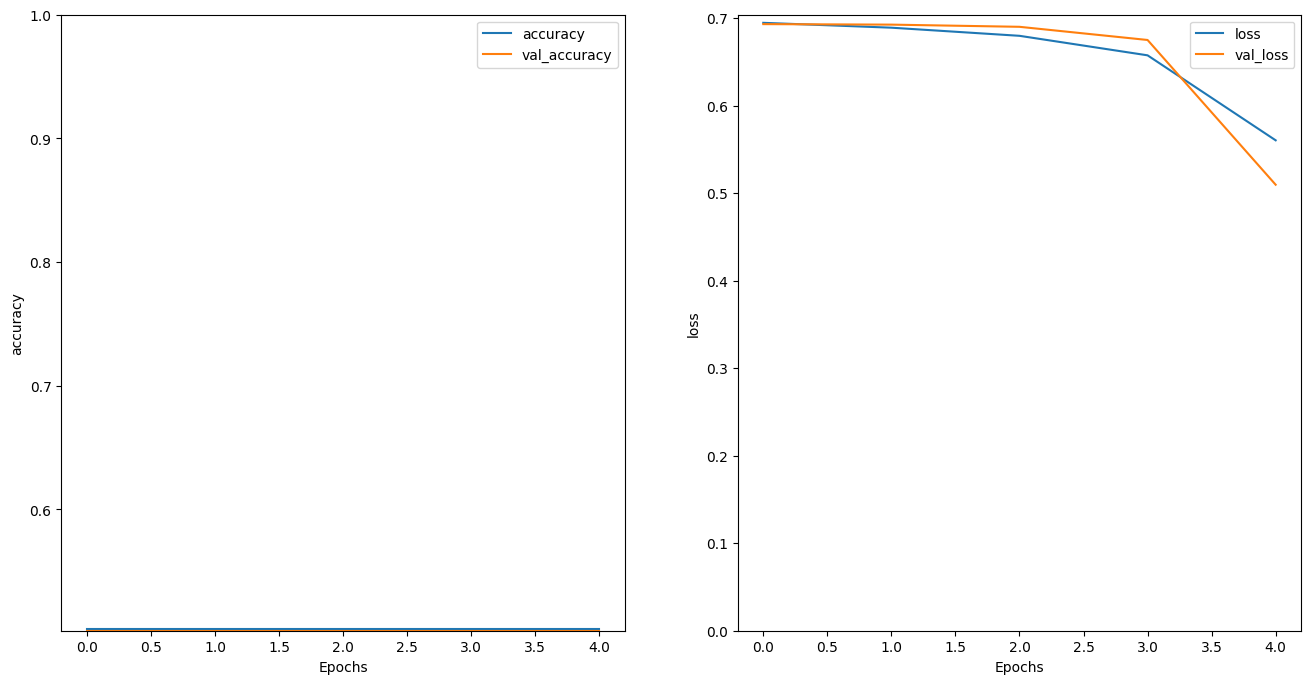

In [43]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [47]:
sample_text_array = np.array([sample_text], dtype="object")
predictions = model.predict(sample_text_array, verbose=0)

print(predictions)

[[1.]]


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


In [49]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
sample_text_array = np.array([sample_text], dtype="object")
predictions = model.predict(sample_text_array, verbose=0)

print(predictions)


[[1.]]


#Stack LSTM

In [206]:
def create_lstm():
    model = keras.Sequential()

    model.add(encoder)
    model.add(layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                         output_dim=64,mask_zero=True))
    model.add(layers.Dropout(0.7))
    model.add(layers.Bidirectional(layers.LSTM(256,  return_sequences=True)))
    model.add(layers.Bidirectional(layers.LSTM(128)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))


    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [207]:
lstm_model = create_lstm()

In [208]:
lstm_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_27 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_46 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_47 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [209]:
# To provide more efficienly model we define early stopping and checkpoint callback

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitoring the validation metric
    patience=3,  # Number of epochs to wait without improvement before stopping
    restore_best_weights=True,  # Restore the best weights of the model
    verbose=1  # Show information in the console
)



checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  # File name to save the model
    save_best_only=True,  # Save only the best model
    monitor='val_loss',  # Monitoring the validation metric
    mode='min',  # Looking for the minimum of 'val_loss'
    verbose=1  # Show information in the console
)


In [210]:
callbacks = [
    checkpoint_callback,
    early_stopping_callback
]

In [211]:
history_lstm = lstm_model.fit(train_ds,
    validation_data=val_ds,
    epochs=50,
    verbose=2,
    callbacks=callbacks
)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.42012, saving model to best_model.keras
375/375 - 31s - 84ms/step - accuracy: 0.6294 - loss: 0.6208 - val_accuracy: 0.8273 - val_loss: 0.4201
Epoch 2/50

Epoch 2: val_loss improved from 0.42012 to 0.40429, saving model to best_model.keras
375/375 - 26s - 70ms/step - accuracy: 0.8205 - loss: 0.4016 - val_accuracy: 0.8400 - val_loss: 0.4043
Epoch 3/50

Epoch 3: val_loss improved from 0.40429 to 0.34600, saving model to best_model.keras
375/375 - 28s - 73ms/step - accuracy: 0.8503 - loss: 0.3500 - val_accuracy: 0.8573 - val_loss: 0.3460
Epoch 4/50

Epoch 4: val_loss did not improve from 0.34600
375/375 - 26s - 70ms/step - accuracy: 0.8608 - loss: 0.3285 - val_accuracy: 0.8333 - val_loss: 0.3821
Epoch 5/50

Epoch 5: val_loss improved from 0.34600 to 0.31248, saving model to best_model.keras
375/375 - 41s - 109ms/step - accuracy: 0.8673 - loss: 0.3145 - val_accuracy: 0.8683 - val_loss: 0.3125
Epoch 6/50

Epoch 6: val_loss improved from 0.

In [212]:
test_loss_lstm, test_acc_lstm = lstm_model.evaluate(val_ds)

print('Test Loss:', test_loss_lstm)
print('Test Accuracy:', test_acc_lstm)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8651 - loss: 0.3150
Test Loss: 0.3039529025554657
Test Accuracy: 0.8740000128746033


(0.0, 0.6385943681001663)

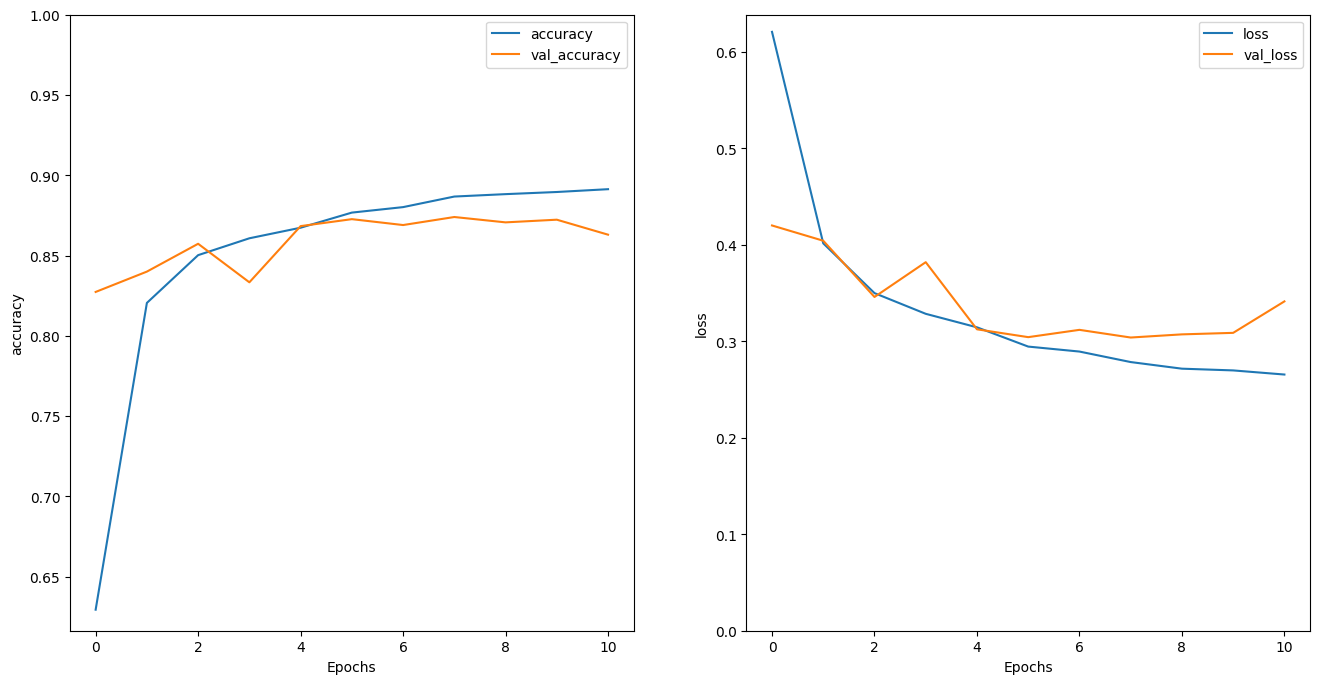

In [213]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_lstm, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_lstm, 'loss')
plt.ylim(0, None)


In [214]:
sample_text_lstm = ('The movie not cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
sample_text_array_lstm = np.array([sample_text_lstm], dtype="object")
predictions_lstm = lstm_model.predict(sample_text_array_lstm, verbose=0)

print(predictions_lstm)


[[0.6802549]]


#GRU

In [177]:
def create_model_gru():
    model = keras.Sequential()

    model.add(encoder)
    model.add(layers.Embedding(input_dim=len(encoder.get_vocabulary()),
                                         output_dim=64,mask_zero=True))
    model.add(layers.GRU(128))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [178]:
model_gru = create_model_gru()

In [179]:
model_gru.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_1                 │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_21 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [180]:
history_gru = model_gru.fit(train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=2
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


375/375 - 56s - 149ms/step - accuracy: 0.4959 - loss: 0.6906 - val_accuracy: 0.4800 - val_loss: 0.6773
Epoch 2/5
375/375 - 8s - 20ms/step - accuracy: 0.4959 - loss: 0.5690 - val_accuracy: 0.4800 - val_loss: 0.4504
Epoch 3/5
375/375 - 7s - 20ms/step - accuracy: 0.4959 - loss: 0.3634 - val_accuracy: 0.4800 - val_loss: 0.3447
Epoch 4/5
375/375 - 7s - 19ms/step - accuracy: 0.4959 - loss: 0.3028 - val_accuracy: 0.4800 - val_loss: 0.3124
Epoch 5/5
375/375 - 8s - 21ms/step - accuracy: 0.4959 - loss: 0.2855 - val_accuracy: 0.4800 - val_loss: 0.3166


In [181]:
test_loss_gru, test_acc_gru = model_gru.evaluate(val_ds)

print('Test Loss:', test_loss_gru)
print('Test Accuracy:', test_acc_gru)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4828 - loss: 0.3276
Test Loss: 0.3166254162788391
Test Accuracy: 0.47999998927116394


(0.0, 0.7108336523175239)

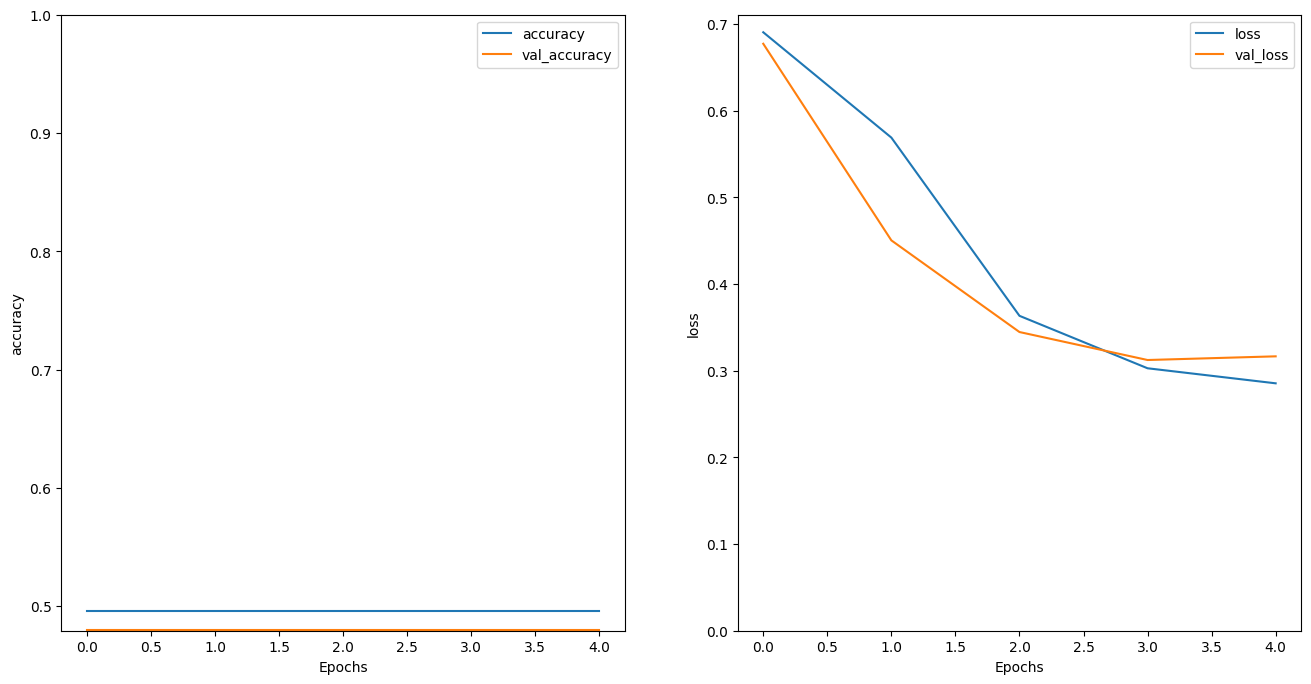

In [182]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history_gru, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_gru, 'loss')
plt.ylim(0, None)
